<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter3ScalingDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The overall point of the following couple of notebooks is all of the ways we can go about optimizing the performance of our model.
We will start of with dataset augmentation techniques.

# Scaling datasets

This is the process of ensuring that all of our variables in the vectors/tensors that we use for inference and training are in the range of 0 - 1. When dealing with images, we divide the value by 255.

In [ ]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train = True)
tr_images = fmnist.data
tr_targets = fmnist.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [ ]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float() / 255 #normalizing the images
    x = x.view(-1, 28*28) #flatten the image
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x,y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)
  

Fetch the data

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
  return trn_dl

Create the model

In [ ]:
from torch.optim import SGD,Adam
def get_model():
  model = nn.Sequential(
              nn.Linear(28 * 28, 1000),
              nn.ReLU(),
              nn.Linear(1000,10)
          ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr = 1e-2)
  return model, loss_fn, optimizer 

Funcs for training and validating

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train() 
  prediction = model(x)
  batch_loss = loss_fn(prediction, y) #loss for the current batch
  batch_loss.backward() #backprop
  optimizer.step() #update model
  optimizer.zero_grad() #calculate backprop separetely for each batch
  return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1) #max in each row of predictions
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()



Actually train the model

In [ ]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(10):
  print(f'{epoch}. epoch')
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate (iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x,y,model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)
  

0. epoch
1. epoch
2. epoch
3. epoch
4. epoch
5. epoch
6. epoch
7. epoch
8. epoch
9. epoch


Let's see how well it performed

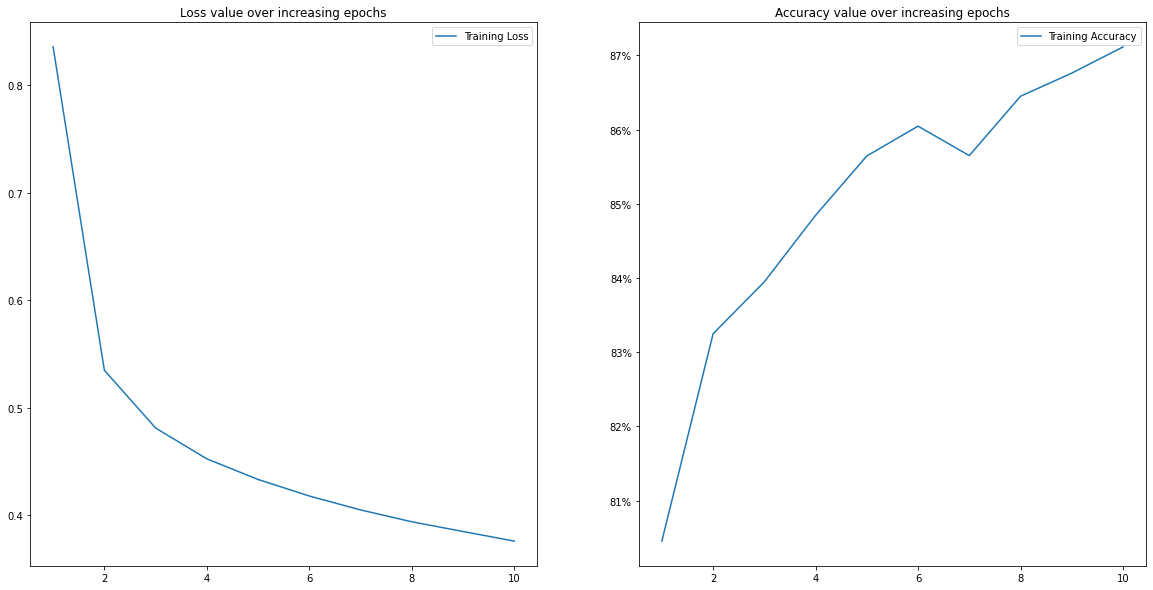

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(10)+1
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()


We can clearly see that the training loss drops as the epoch go, getting lower with each passing epoch. We can also see that the accuracy has increased and has got up to ~85%, which is much better that the first example with non normalized/scaled data where it was around 12%

**Why did the scalling help?**

Here it has to do with the Sigmoid function calculated in the CrossEntropyLoss. It could have also been the last layer of the NN, after the last linear layer.
sigmoid = 1 / (1 + exp-(w*input))
When the inputs range from 0 - 255, like in image data, for any values of the weights over and equal to 0.1, and when the weights are larger, the exponential function will be close to 0 and thus the sigmoid will be 1. Meaning there is little variation in the output.
When we scale the data, the sigmoid has muhc more variation as the weights vary and becomes more sensitive to the dataset.

# **Varying batch size**

In the previous example, batch size of 32 was used, meaning a larger number of updated per epoch, around 1875 since 60000/32 is roughly 1875. We also didn't consider model's performance on the validation dataset.

We will first download the validation dataset

In [ ]:
val_fmnist =datasets.FashionMNIST(data_folder,download=True, train=False) #train = False is what gives us the val dataset
val_images = val_fmnist.data
val_targets = val_fmnist.targets

This is a function to determine the loss on the validation dataset

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

To get the datasets

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val,batch_size = len(val_images), shuffle = False)
  return trn_dl, val_dl

Train the model again, and calculate the validation loss

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print(f'{epoch}. epoch')
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate (iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x,y,model)
    epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    validation_loss = val_loss(x,y,model)
  val_epoch_accuracy = np.mean(val_is_correct)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)

0. epoch
1. epoch
2. epoch
3. epoch
4. epoch
5. epoch
6. epoch
7. epoch
8. epoch
9. epoch


Let's see the performance on the validation dataset

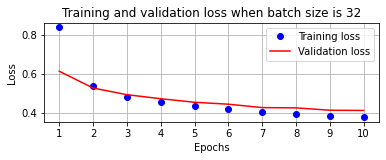

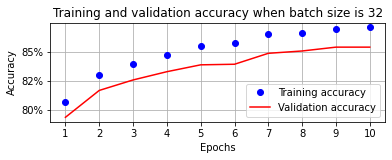

In [ ]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()


The validation loss function goes down as the model is learning. Also, the accuracy of the model on validation dataset is around ~85%. What will happen when we increase batch size to 10000?

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 10000, shuffle = True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val,batch_size = len(val_images), shuffle = False)
  return trn_dl, val_dl

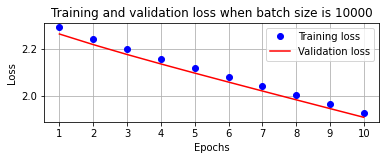

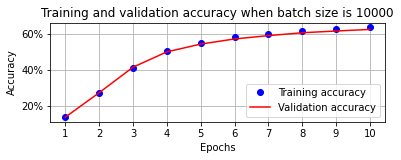

In [ ]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

We can see that even though we updated the weights on more example at once, taking the gradient of 10k example, that only lead to 6 updated for the dataset of 60k images and that lead to achievning lower accuracy of the model on the given dataset.

# Learning rate variation with a scaled dataset 

Using ADAM optimizer

In [ ]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-1)
  return model, loss_fn, optimizer

Using batch size of 32

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val,batch_size = len(val_images), shuffle = False)
  return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print(f'{epoch}. epoch')
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate (iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x,y,model)
    epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    validation_loss = val_loss(x,y,model)
  val_epoch_accuracy = np.mean(val_is_correct)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)

0. epoch
1. epoch
2. epoch
3. epoch
4. epoch
5. epoch
6. epoch
7. epoch
8. epoch
9. epoch


Let's see the results

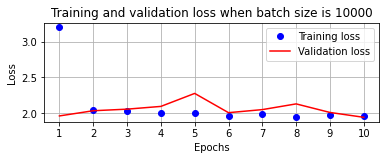

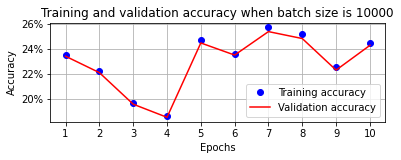

In [ ]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Using ADAM with this learning rate, a using the defalut values for beta 1 and beta 2 hyperparams, we achieved worse results that the standard SGD with the same learning rate. What happens when we lower the learning rate?

Learning rate is 100 times smaller i.e. ist 0.001 now

In [ ]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

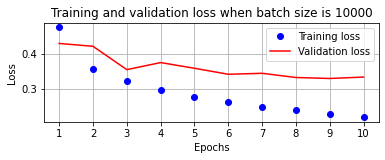

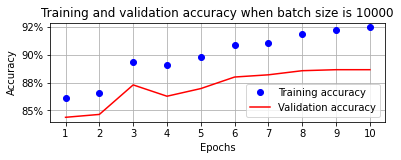

In [ ]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

We can see that the with the learning rate being smaller and with the Adam optimizer, our model has achieved ~89% accuracz, which is better than the regular SGD with higher learning rate.

Learnin rate is even smaller now, it's 10000 times smaller than at the begining.

In [ ]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-5)
  return model, loss_fn, optimizer

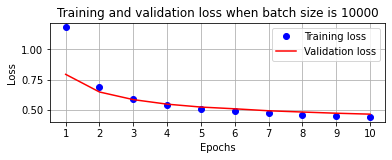

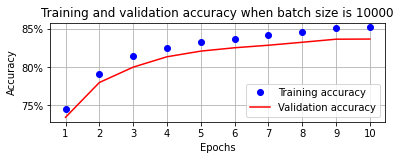

In [ ]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()